In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Bidirectional
import keras.callbacks

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Using past 48 hours to predict next 48 hours


In [3]:
df_0 = pd.read_json("https://data.melbourne.vic.gov.au/resource/b2ak-trbp.json?$limit=50000&$offset=2546125")

In [6]:
df0 = pd.read_json("https://data.melbourne.vic.gov.au/resource/b2ak-trbp.json?$offset=2546125")

In [288]:
data = pd.read_csv("../data/pedestrian.csv")

In [289]:
data = data.iloc[2079491:,]
data.head(2)

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
2079491,2079941,01/01/2018 12:00:00 AM,2018,January,1,Monday,0,4,Town Hall (West),3052.0
2079492,2079942,01/01/2018 12:00:00 AM,2018,January,1,Monday,0,5,Princes Bridge,1757.0


In [427]:
data = pd.read_csv('pedestrian_temp.csv')

In [428]:
data.head(2)

,date_time,sensor_id,sensor_name,hourly_counts,latitude,longitude
0,01/10/2018 0:00,5,Princes Bridge,123.0,-37.818742,144.967877
1,01/10/2018 1:00,5,Princes Bridge,46.0,-37.818742,144.967877


In [429]:
#df = data.iloc[:,[1,7,9]] # Select date,sensor,counts
df = data.iloc[:,[0,1,3]]

In [430]:
df.head(2)

,date_time,sensor_id,hourly_counts
0,01/10/2018 0:00,5,123.0
1,01/10/2018 1:00,5,46.0


In [432]:
sid = 104
#df = df[df['Sensor_ID']==sid]
df = df[df['sensor_id']==sid]

In [433]:
split_ratio = 0.8
N=round(len(df)*split_ratio)

In [434]:
data_train = df.iloc[:N,]
data_test = df.iloc[N:,]

In [435]:
# Change into datetime
# data_train["Date_Time"] = pd.to_datetime(data_train["Date_Time"])
# data_test["Date_Time"] = pd.to_datetime(data_test["Date_Time"])

data_train["date_time"] = pd.to_datetime(data_train["date_time"])
data_test["date_time"] = pd.to_datetime(data_test["date_time"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [437]:
df_TownHallWest_train = data_train
df_TownHallWest_test = data_test

In [438]:
df_TownHallWest_train = df_TownHallWest_train.set_index(['date_time'])
df_TownHallWest_train = df_TownHallWest_train.drop(columns=['sensor_id'])

In [439]:
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    training_scaled = scaler.fit_transform(dataset)
    return training_scaled

def build_X(training_scaled):
    X_train = []
    lookback = 168

    for i in range(lookback, len(training_scaled)):
        X_train.append(training_scaled[i-lookback:i,0])   
        
    X_train = np.array(X_train)
    return X_train

def build_Y(training_scaled):
    Y_train = []
    lookback = 168

    for i in range(lookback, len(training_scaled)):
        Y_train.append(training_scaled[i,0])
        
    Y_train = np.array(Y_train)
    return Y_train

In [440]:
X_train = build_X(scale_data(df_TownHallWest_train))
Y_train = build_Y(scale_data(df_TownHallWest_train))

In [441]:
X_train

array([[0.00459921, 0.00197109, 0.00131406, ..., 0.0499343 , 0.03219448,
        0.00985545],
       [0.00197109, 0.00131406, 0.00328515, ..., 0.03219448, 0.00985545,
        0.0151117 ],
       [0.00131406, 0.00328515, 0.01708279, ..., 0.00985545, 0.0151117 ,
        0.00591327],
       ...,
       [0.15045992, 0.15045992, 0.15045992, ..., 0.06570302, 0.09329829,
        0.11235217],
       [0.15045992, 0.15045992, 0.1412615 , ..., 0.09329829, 0.11235217,
        0.12943495],
       [0.15045992, 0.1412615 , 0.15045992, ..., 0.11235217, 0.12943495,
        0.1544021 ]])

In [442]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [443]:
# Keras settings
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [444]:
lookback = 168
epochs = 20
batch_size = 32

model = Sequential()
model.add(Bidirectional(LSTM(batch_size, input_shape=(lookback,1), return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(batch_size, input_shape=(lookback,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(batch_size, input_shape=(lookback,1)))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[earlystop], validation_split=0.2)

Train on 2660 samples, validate on 666 samples
Epoch 1/20
2660/2660 [==============================] - 74s 28ms/step - loss: 0.0476 - val_loss: 0.0327
Epoch 2/20
2660/2660 [==============================] - 65s 24ms/step - loss: 0.0266 - val_loss: 0.0309
Epoch 3/20
2660/2660 [==============================] - 68s 26ms/step - loss: 0.0239 - val_loss: 0.0302
Epoch 4/20
2660/2660 [==============================] - 65s 24ms/step - loss: 0.0228 - val_loss: 0.0291
Epoch 5/20
2660/2660 [==============================] - 65s 24ms/step - loss: 0.0235 - val_loss: 0.0275
Epoch 6/20
2660/2660 [==============================] - 64s 24ms/step - loss: 0.0219 - val_loss: 0.0264
Epoch 7/20
2660/2660 [==============================] - 65s 24ms/step - loss: 0.0217 - val_loss: 0.0254
Epoch 8/20
2660/2660 [==============================] - 65s 24ms/step - loss: 0.0214 - val_loss: 0.0245
Epoch 9/20
2660/2660 [==============================] - 65s 24ms/step - loss: 0.0201 - val_loss: 0.0247
Epoch 10/20
2660/

## Save Model

2, 58, 17, 22, 49, 29, 110, 109, 13, 37, 3, 4, 43, 35, 10, 52, 104

In [446]:
sid

104

In [456]:
# serialize model to JSON
model_json = model.to_json()
with open("104_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("104_model.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['val_loss', 'loss'])


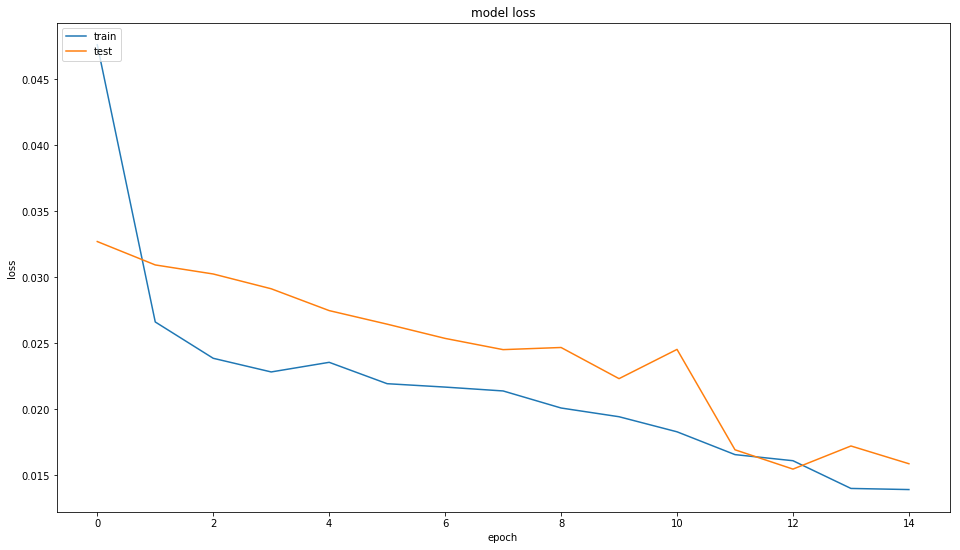

In [447]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing

In [448]:
df_TownHallWest_test.head(1)

,date_time,sensor_id,hourly_counts
234998,2019-02-23 14:00:00,104,215.0


In [449]:
df_TownHallWest_test = df_TownHallWest_test.set_index(['date_time'])
df_TownHallWest_test = df_TownHallWest_test.drop(columns=['sensor_id'])

In [450]:
df_save = df_TownHallWest_test
#df_TownHallWest_test = df_save
df_TownHallWest_test.head(1)

,hourly_counts
date_time,
2019-02-23 14:00:00,215.0


In [451]:
# Just use "r" records 
r = 168

df_x = df_TownHallWest_test.iloc[:r*2]
#df_x = df_x.set_index(['Date_Time'])
#df_x = df_x.drop(columns=['index'])
#df_x = pd.DataFrame(df_x)

In [452]:
# make predictions
sc = MinMaxScaler(feature_range = (0,1))
X_test = sc.fit_transform(df_x)
X_test = build_X(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
test_predict = model.predict(X_test)
test_predict = sc.inverse_transform(test_predict)

In [453]:
#data_test.reset_index(level=0, inplace=True)
test_predict = pd.DataFrame(test_predict)
test_predict = test_predict.clip(lower=0)
#test_predict.index = test_predict.index + 20

In [454]:
df_test = df_TownHallWest_test
df_test.reset_index(level=0, inplace=True)
df_test = df_test.drop(columns=('date_time'))

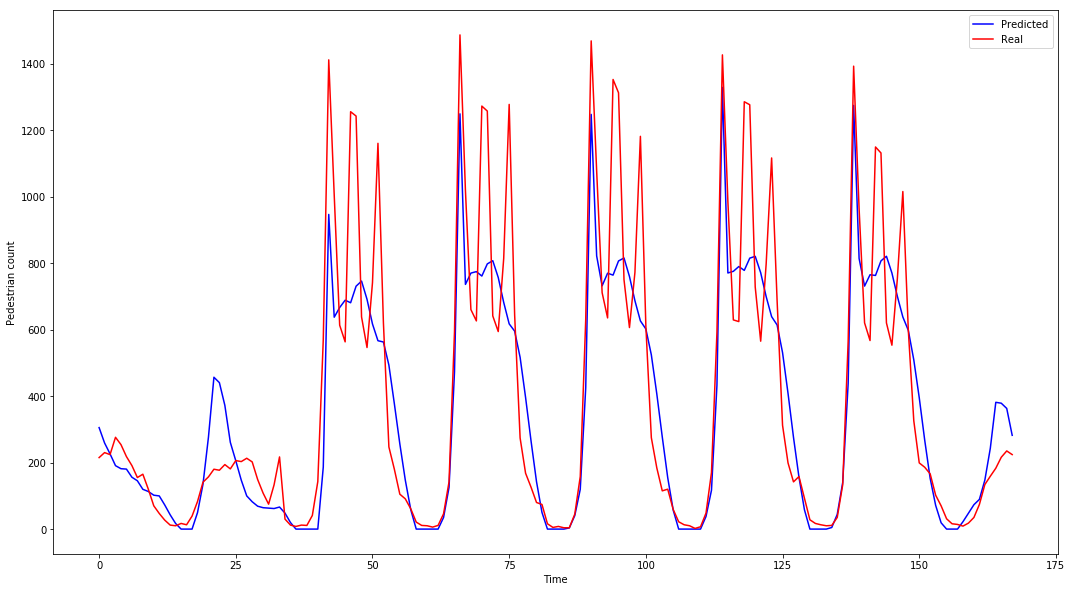

In [455]:
plt.figure(figsize=(18,10))
plt.plot(test_predict.iloc[0:168], color = 'blue', label='Predicted')
plt.plot(df_test.iloc[0:168], color = 'red', label='Real')
plt.xlabel('Time')
plt.ylabel('Pedestrian count')
plt.legend()
plt.show()